In [1]:
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")


# standard
import json
from collections import defaultdict
import pandas as pd
import numpy as np
import seaborn as sns
from statistics import median
from matplotlib import pyplot as plt
from sklearn import metrics
import matplotlib.ticker as ticker
from itertools import combinations
from scipy import stats 
import pickle

# my lib
import PPILinkPred as pred
import genData_helper as helper

In [2]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return h

In [3]:
def standardize_plots(precsList, recsList, decimalPt):
    # note that the rec is trimmed in favor of the smallest rec (both min max)
    # corr recList to decimal pt -> create a rec list with minimum unit interval
    # -> map prec of each list to the rec list position, dont exists then np.nan -> use pandas interpolate
    corrStr = "{0:."+str(decimalPt)+"f}"
    tmp = []
    for recs in recsList: tmp.append(np.asarray([float(corrStr.format(rec)) for rec in recs]))
    recsList = tmp.copy()
    flattenRecs = np.asarray(recsList).flatten()
    minBoundRec, maxBoundRec = max([recs[0] for recs in recsList]), min([recs[-1] for recs in recsList])
    baseRecs = np.asarray([i for i in range(int(minBoundRec*(10**decimalPt)), int(maxBoundRec*(10**decimalPt)))])/10**decimalPt
    alignedPrecsList = []
    for i in range(len(precsList)):
        precsMap = {}
        for k in baseRecs: precsMap[k] = np.nan
        for j in range(len(precsList[i])):
            if recsList[i][j] in precsMap: precsMap[recsList[i][j]] = precsList[i][j]
        mappedPrecs = pd.Series(list(precsMap.values()))
        alignedPrecsList.append(list(np.asarray(mappedPrecs.interpolate())))
    return alignedPrecsList, baseRecs

def get_plots_outline(plots, boundFunc):
    # func can be: min, max, avg, median
    invertedArr = np.transpose(np.asarray(plots))
    boundPlot = [boundFunc(arr) for arr in invertedArr]
    return boundPlot

# init metadata

In [4]:
colors = {
    "L3E1_f1": "tab:blue",
    "L3E1_f2": "tab:olive",
    "L3E_f1Alt": "navy",
    "L3E_f2Alt": "gold",
    "L3": "tab:orange",
    "CN": "tab:green",
    "CRA": "tab:red",
    "CH2": "tab:brown",
    "Sim": "tab:purple",
    "rand": "tab:grey",
    "countP4": "black"
}

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "random", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
methods_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "countP4", "L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
abbrev_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no.\n of $P_{4}$", "L3E'\n($f_{1}$)", "L3E'\n($f_{2}$)", "L3E\n($f_{1}$)", "L3E\n($f_{2}$)"]
label_map = ["CN", "L3", "CRA", "Sim", "CH2", "rand", "no. of $P_{4}$", "L3E'($f_{1}$)", "L3E'($f_{2}$)", "L3E($f_{1}$)", "L3E($f_{2}$)"]

methods_names = dict(zip(methods, methods_map))
abbrevs = dict(zip(methods_map, abbrev_map))
labels = dict(zip(methods_map, label_map))

# read data into df

In [7]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]
ds_names = ['bioGRID_human', 'STRING_human', 'HuRI', 'MINT_human']

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,L3E1_f1,bioGRID_human,0,1.000000,0.000004
1,50,1,L3E1_f1,bioGRID_human,0,0.500000,0.000004
2,50,2,L3E1_f1,bioGRID_human,0,0.666667,0.000009
3,50,3,L3E1_f1,bioGRID_human,0,0.750000,0.000013
4,50,4,L3E1_f1,bioGRID_human,0,0.800000,0.000018
...,...,...,...,...,...,...,...
16694795,50,11156,L3E_f2Alt,MINT_human,9,0.157211,0.157140
16694796,50,11157,L3E_f2Alt,MINT_human,9,0.157286,0.157230
16694797,50,11158,L3E_f2Alt,MINT_human,9,0.157272,0.157230
16694798,50,11159,L3E_f2Alt,MINT_human,9,0.157348,0.157319


In [7]:
# import all prec rec into data structure:
# col: rank, method, ds, trial, prec, rec

methods = ["commonNeighbor", "L3Normalizing", "CRA", "Sim", "CH2_L3", "L3E1_f1", "L3E1_f2", "random"]
ds_names = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']

df = defaultdict(list)

for ds in ds_names:
    for method in methods:
        for i in range(0,10):
            precRec = {}
            with open("./precision_recall_out/{}_{}_topPPI_{}.json".format(method, ds, i), "r") as f:
                precRec = json.loads(f.read())

                df["randSz"] += [50 for j in range(len(precRec['prec']))]
                df["rank"] += [j for j in range(len(precRec['prec']))]
                df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                df['ds'] += [ds for j in range(len(precRec['prec']))]
                df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                df['prec'] += precRec['prec']
                df['rec'] += precRec['rec']

for randSz in range(60, 100, 10):
    for ds in ds_names:
        for method in methods:
            for i in range(0,10):
                precRec = {}
                with open("./precision_recall_out/{}_{}_randSz{}_topPPI_{}.json".format(method, ds, randSz, i), "r") as f:
                    precRec = json.loads(f.read())

                    df["randSz"] += [randSz for j in range(len(precRec['prec']))]
                    df["rank"] += [j for j in range(len(precRec['prec']))]
                    df['method'] += [methods_names[method] for j in range(len(precRec['prec']))]
                    df['ds'] += [ds for j in range(len(precRec['prec']))]
                    df['trial'] += [int(i) for j in range(len(precRec['prec']))]
                    df['prec'] += precRec['prec']
                    df['rec'] += precRec['rec']
                
df = pd.DataFrame(df)
df

,randSz,rank,method,ds,trial,prec,rec
0,50,0,CN,bioGRID_human,0,0.000000,0.000000
1,50,1,CN,bioGRID_human,0,0.000000,0.000000
2,50,2,CN,bioGRID_human,0,0.000000,0.000000
3,50,3,CN,bioGRID_human,0,0.250000,0.000004
4,50,4,CN,bioGRID_human,0,0.200000,0.000004
...,...,...,...,...,...,...,...
159120175,90,46008,rand,HuRI,9,0.000174,0.001565
159120176,90,46009,rand,HuRI,9,0.000174,0.001565
159120177,90,46010,rand,HuRI,9,0.000174,0.001565
159120178,90,46011,rand,HuRI,9,0.000174,0.001565


In [8]:
# neglecting L3E(f1) and L3E(f2) and parsing separately when needed
df.to_pickle("./precision_recall_out/full_df_human.pkl")

In [5]:
df = pd.read_pickle("./precision_recall_out/full_df_human.pkl")

# AUC of precision-recall, ranked from low to high

In [ ]:
auc_map = {}
methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]

for randSz in range(50, 51, 10):
    print(randSz)
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            
sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 51, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

In [29]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 100, 10):
    print(randSz)
    auc_map[randSz] = {}
    for ds in set(df['ds']):
        auc_map[randSz][ds] = defaultdict(list)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            for i in range(len(prec)):
                auc_map[randSz][ds][method].append(metrics.auc(rec[i], prec[i]))
            
with open("./precision_recall_out/auc_human.pkl", "wb") as f:
    pickle.dump(auc_map, f, protocol=pickle.HIGHEST_PROTOCOL)

sorted_mean_auc, err_auc = {}, {}
for randSz in range(50, 100, 10):
    sorted_mean_auc[randSz], err_auc[randSz] = {}, {}
    for ds in auc_map[randSz]:
        sorted_mean_auc[randSz][ds], err_auc[randSz][ds] = {}, {}
        for method in auc_map[randSz][ds]:
            sorted_mean_auc[randSz][ds][method] = np.mean(auc_map[randSz][ds][method])
            err_auc[randSz][ds][method] = np.std(auc_map[randSz][ds][method])
        sorted_mean_auc[randSz][ds] = dict(sorted(sorted_mean_auc[randSz][ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)
with open("./precision_recall_out/mean_auc_human.pkl", "wb") as f:
    pickle.dump(sorted_mean_auc, f, protocol=pickle.HIGHEST_PROTOCOL)
with open("./precision_recall_out/auc_err_human.pkl", "wb") as f:
    pickle.dump(err_auc, f, protocol=pickle.HIGHEST_PROTOCOL)

50
60
70
80
90
{50: {'HuRI': {'rand': 1.2256176506665125e-06, 'CN': 0.011775301052105152, 'CRA': 0.018154198612206886, 'L3E1_f2': 0.06219906625927215, 'CH2': 0.07241790334595799, 'Sim': 0.07343609729038847, 'L3': 0.0759230978471003, 'L3E1_f1': 0.08721972941784586}, 'STRING_human': {'rand': 2.8050481109114833e-06, 'CN': 0.29330397197242464, 'CH2': 0.30595051858693034, 'Sim': 0.3532440111437695, 'L3': 0.37068691728097647, 'CRA': 0.3902906081204821, 'L3E1_f2': 0.4268945041081783, 'L3E1_f1': 0.5001641945064522}, 'bioGRID_human': {'rand': 9.916971549433078e-07, 'CN': 0.03939442164283261, 'L3': 0.06353454721794612, 'CRA': 0.06542029888810924, 'CH2': 0.06655697551721047, 'Sim': 0.0780860280683517, 'L3E1_f2': 0.08886885825465075, 'L3E1_f1': 0.10841898115049456}, 'MINT_human': {'rand': 3.8477996442233964e-07, 'CN': 0.0018981621138466427, 'CRA': 0.0035038635971551208, 'Sim': 0.018291801979220444, 'L3E1_f2': 0.04413072614964211, 'CH2': 0.05011927814324668, 'L3': 0.06406404330777883, 'L3E1_f1': 0.

In [6]:
sorted_mean_auc, err_auc, auc_map = {}, {}, {}

with open("./precision_recall_out/auc_human.pkl", "rb") as f:
    auc_map = pickle.load(f)
with open("./precision_recall_out/mean_auc_human.pkl", "rb") as f:
    sorted_mean_auc = pickle.load(f)
with open("./precision_recall_out/auc_err_human.pkl", "rb") as f:
    err_auc = pickle.load(f)

In [14]:
# the decreasing AUC of rand
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID Human', 'STRING Human', 'MINT Human', 'HuRI']

for i in range(len(dss)):
    ds = dss[i]
    buildStr = ""
    for randSz in range(50, 100, 10):
        aucVal = np.format_float_scientific(np.float32(sorted_mean_auc[randSz][ds]['rand']), precision=3)
        buildStr += " & "+str(aucVal)
    print("\\cellcolor{gray!15} "+dsNames[i]+" "+buildStr+" \\\\ \\hline")

\cellcolor{gray!15} BioGRID Human  & 9.917e-07 & 8.432e-07 & 6.524e-07 & 4.690e-07 & 2.484e-07 \\ \hline
\cellcolor{gray!15} STRING Human  & 2.805e-06 & 2.51e-06 & 2.052e-06 & 1.497e-06 & 8.719e-07 \\ \hline
\cellcolor{gray!15} MINT Human  & 3.848e-07 & 3.310e-07 & 3.485e-07 & 2.235e-07 & 1.273e-07 \\ \hline
\cellcolor{gray!15} HuRI  & 1.226e-06 & 9.521e-07 & 8.145e-07 & 3.698e-07 & 4.853e-07 \\ \hline


# p-value of PR AUC

In [40]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'L3'], ['L3E1_f1', 'L3']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID_human L3E1_f1 L3E1_f2: 1.2105236158555802e-09
STRING_human L3E1_f1 L3E1_f2: 7.788659413691787e-19
MINT_human L3E1_f1 L3: 1.5747302450107275e-06
HuRI L3E1_f1 L3: 5.135920052142221e-11


In [12]:
pairs = {
    60: [['L3E1_f2', 'L3E1_f1'], ['L3E1_f2', 'L3E1_f1'], ['L3E1_f1', 'L3'], ['L3E1_f1', 'Sim']],
    70: [['L3E1_f1', 'L3E1_f2'], ['L3E1_f2', 'L3E1_f1'], ['L3E1_f1', 'L3'], ['L3E1_f1', 'Sim']],
    80: [['Sim', 'L3E1_f1'], ['CRA', 'L3E1_f1'], ['L3', 'L3E1_f1'], ['L3E1_f1', 'Sim']],
    90: [['L3E1_f1', 'L3E1_f2'], ['L3E1_f2', 'L3E1_f1'], ['L3', 'L3E1_f1'], ['L3E1_f1', 'Sim']]
}
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
for randSz in range(60, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        pair = pairs[randSz][i]
        pop1 = auc_map[randSz][ds][pair[0]]
        pop2 = auc_map[randSz][ds][pair[1]]
        pVal = stats.ttest_ind(pop1, pop2)[1]
        print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

60
bioGRID_human L3E1_f2 L3E1_f1: 6.735465715714275e-10
STRING_human L3E1_f2 L3E1_f1: 8.970812089339013e-17
MINT_human L3E1_f1 L3: 7.300520076388361e-08
HuRI L3E1_f1 Sim: 1.0565272891700317e-11
70
bioGRID_human L3E1_f1 L3E1_f2: 5.870599031356056e-14
STRING_human L3E1_f2 L3E1_f1: 9.68306707976997e-16
MINT_human L3E1_f1 L3: 1.486836540723042e-09
HuRI L3E1_f1 Sim: 5.2530520149777105e-08
80
bioGRID_human Sim L3E1_f1: 1.0201279439028521e-15
STRING_human CRA L3E1_f1: 5.579637776768068e-22
MINT_human L3 L3E1_f1: 1.9052221361853615e-10
HuRI L3E1_f1 Sim: 1.3549426678727813e-07
90
bioGRID_human L3E1_f1 L3E1_f2: 0.006605367491096656
STRING_human L3E1_f2 L3E1_f1: 6.574477773880913e-10
MINT_human L3 L3E1_f1: 3.710002220822405e-06
HuRI L3E1_f1 Sim: 8.32372543650254e-06


In [23]:
# every p val to rand
# sample to do: top 2 both to third, between top 2
for randSz in range(50, 100, 10):
    print(randSz)
    for i in range(len(dss)):
        ds = dss[i]
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            print("{} {} {}: {}".format(ds, pair[0], pair[1], pVal))

50
bioGRID_human rand CN: 2.06796775644011e-19
bioGRID_human rand CRA: 1.0690298384571808e-26
bioGRID_human rand L3: 6.319371610899748e-24
bioGRID_human rand CH2: 5.967651956349944e-30
bioGRID_human rand Sim: 2.1253878967735786e-32
bioGRID_human rand L3E1_f1: 3.575037985484542e-24
bioGRID_human rand L3E1_f2: 3.0405984664483635e-25
STRING_human rand CN: 3.246887582605941e-34
STRING_human rand CRA: 4.8311460877466335e-39
STRING_human rand L3: 1.232847810894327e-35
STRING_human rand CH2: 3.68116321821721e-29
STRING_human rand Sim: 5.233886687782714e-35
STRING_human rand L3E1_f1: 1.1347597118697338e-35
STRING_human rand L3E1_f2: 2.3393012787008475e-36
MINT_human rand CN: 4.0305244178878575e-16
MINT_human rand CRA: 9.857172077346213e-14
MINT_human rand L3: 2.7013078806075766e-24
MINT_human rand CH2: 1.1883943018553305e-24
MINT_human rand Sim: 7.637594266719969e-18
MINT_human rand L3E1_f1: 9.167768941635157e-26
MINT_human rand L3E1_f2: 6.839133037072731e-22
HuRI rand CN: 1.344474034241958e-2

In [ ]:
dsNames = ['BioGRID Human', 'STRING Human', 'MINT Human', 'HuRI Human']
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']


for i in range(len(dss)):
    ds = dss[i]
    dsName = dsNames[i]
    print("\\multicolumn{8}{|l|}{\\textbf{"+dsName+"}} \\\\ \\hline")
    for randSz in range(50, 100, 10):
        buildStr = ""
        for pair in [['rand', x] for x in ["CN", "CRA", "L3", "CH2", "Sim", "L3E1_f1", "L3E1_f2"]]:
            pop1 = auc_map[randSz][ds][pair[0]]
            pop2 = auc_map[randSz][ds][pair[1]]
            pVal = stats.ttest_ind(pop1, pop2)[1]
            roundedPVal = np.format_float_scientific(np.float32(pVal), precision=0, trim='-')
            buildStr += "& "+roundedPVal+" "
        print("\\cellcolor{gray!15} "+str(randSz)+"\\% sample size "+buildStr+" \\\\ \\hline")

# precision-recall figure

In [12]:
precRec = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]

for randSz in range(50, 100, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
with open("./precision_recall_out/precRecCurves_human.pkl", "wb") as f:
    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
precRec = {}
methods = ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]

for randSz in range(50, 51, 10):
    precRec[randSz] = {}
    for ds in ds_names:
        precRec[randSz][ds] = defaultdict(dict)
        for method in methods:
            tmp_df = df[(df['ds'] == ds) & (df['method'] == method) & (df['randSz'] == randSz)]
            prec = [list(tmp_df[tmp_df['trial'] == trial]['prec'])[100:] for trial in set(tmp_df['trial'])]
            rec = [list(tmp_df[tmp_df['trial'] == trial]['rec'])[100:] for trial in set(tmp_df['trial'])]
            alignedPrecs, baseRec = standardize_plots(prec, rec, 5)
            upperPrec, lowerPrec, medianPrec = get_plots_outline(alignedPrecs, max), get_plots_outline(alignedPrecs, min), get_plots_outline(alignedPrecs, median)
            precRec[randSz][ds][method]['upperPrec'] = upperPrec
            precRec[randSz][ds][method]['lowerPrec'] = lowerPrec
            precRec[randSz][ds][method]['medianPrec'] = medianPrec
            precRec[randSz][ds][method]['baseRec'] = baseRec
#with open("./precision_recall_out/precRecCurves_human.pkl", "wb") as f:
#    pickle.dump(precRec, f, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
precRec = {}
with open("./precision_recall_out/precRecCurves_human.pkl", "rb") as f:
    precRec = pickle.load(f)

bioGRID_human
STRING_human
MINT_human
HuRI


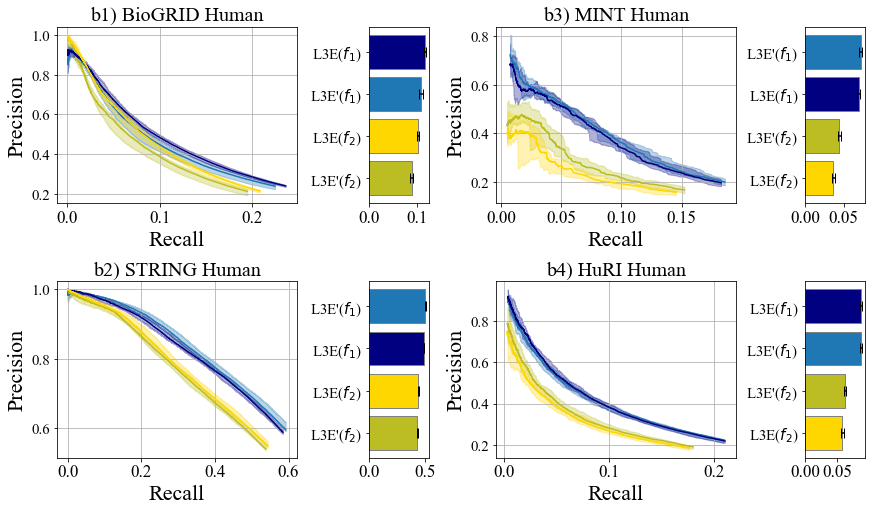

In [11]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7))
widths = [4,1,4,1]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[1, 0])
            , fig.add_subplot(spec[0, 2]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[1, 1])
           , fig.add_subplot(spec[0, 3]), fig.add_subplot(spec[1, 3])]


# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["L3E1_f1", "L3E1_f2", "L3E_f1Alt", "L3E_f2Alt"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                        , precRec[randSz][ds][method]['lowerPrec']
                        , precRec[randSz][ds][method]['upperPrec']
                        , facecolor=colors[method], color=colors[method]
                        , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid()
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    
    xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
    ax.barh([labels[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , xerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
    
plt.savefig("./img_experiments/L3EAlt_PR_human.png", dpi=300)
plt.show()

In [10]:
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt'], ['L3E1_f1', 'L3E_f1Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))
    
pairs = [['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt'], ['L3E1_f2', 'L3E_f2Alt']]
randSz = 50
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[randSz][ds][pairs[i][0]]
    pop2 = auc_map[randSz][ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID_human L3E1_f1 L3E_f1Alt: 7.014696555331001e-05
STRING_human L3E1_f1 L3E_f1Alt: 1.8308759725601683e-06
MINT_human L3E1_f1 L3E_f1Alt: 0.020709327553913585
HuRI L3E1_f1 L3E_f1Alt: 0.4540586252311951
bioGRID_human L3E1_f2 L3E_f2Alt: 1.236370529873045e-08
STRING_human L3E1_f2 L3E_f2Alt: 3.555077452994342e-05
MINT_human L3E1_f2 L3E_f2Alt: 4.013513196992987e-07
HuRI L3E1_f2 L3E_f2Alt: 0.00034566870313010393


bioGRID_human
STRING_human
MINT_human
HuRI


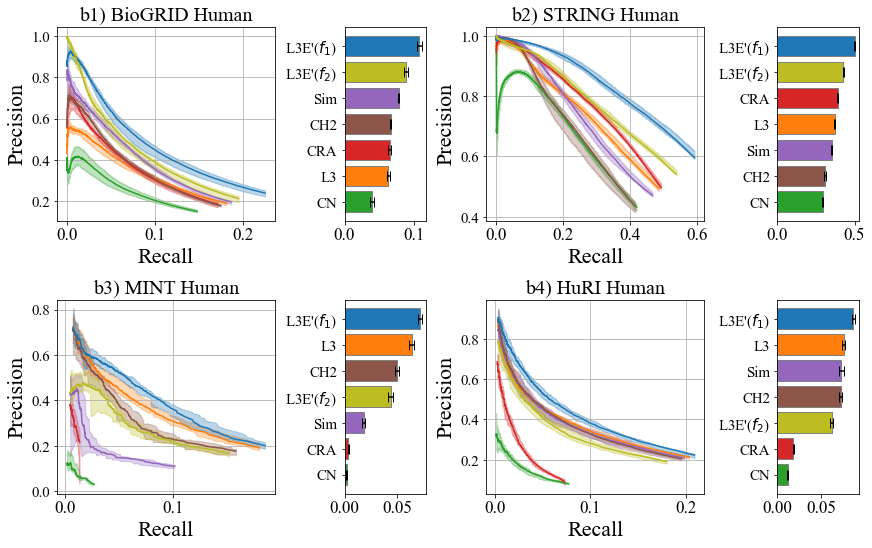

In [12]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7.5))
widths = [4,1.5,4,1.5]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 2]),
            fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[0, 3]),
           fig.add_subplot(spec[1, 1]), fig.add_subplot(spec[1, 3])]


randSz = 50
# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.fill_between(precRec[randSz][ds][method]['baseRec']
                        , precRec[randSz][ds][method]['lowerPrec']
                        , precRec[randSz][ds][method]['upperPrec']
                        , facecolor=colors[method], color=colors[method]
                        , alpha=0.3)
        ax.plot(precRec[randSz][ds][method]['baseRec']
                , precRec[randSz][ds][method]['medianPrec']
                , color=colors[method], label=method)
    ax.set_ylabel("Precision")
    ax.set_xlabel("Recall")
    ax.grid()
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    
    xtick = [k for k in list(sorted_mean_auc[randSz][ds]) if k != 'rand']
    ax.barh([labels[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                      , xerr=[err_auc[randSz][ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
    
plt.savefig("./img_experiments/L3E_human_PR.png", dpi=300)
plt.show()

bioGRID_human
STRING_human
MINT_human
HuRI


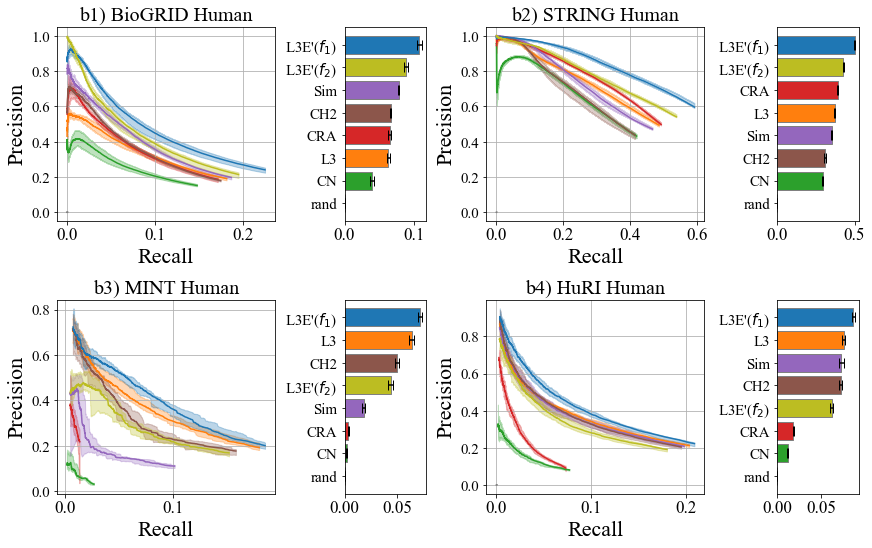

bioGRID_human
STRING_human
MINT_human
HuRI


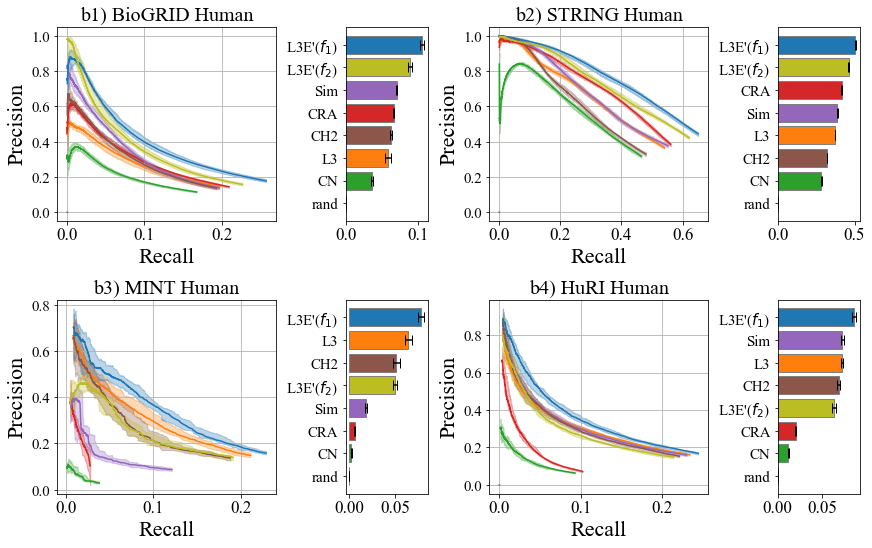

bioGRID_human
STRING_human
MINT_human
HuRI


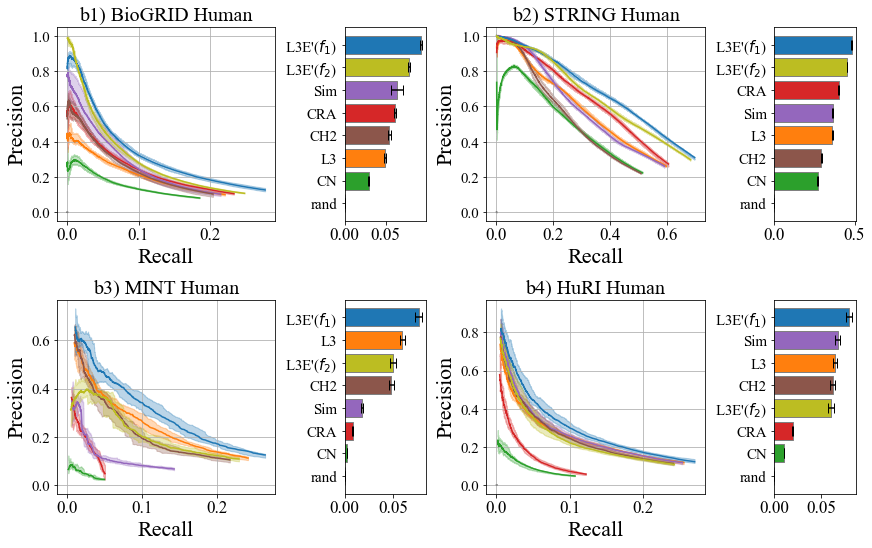

bioGRID_human
STRING_human
MINT_human
HuRI


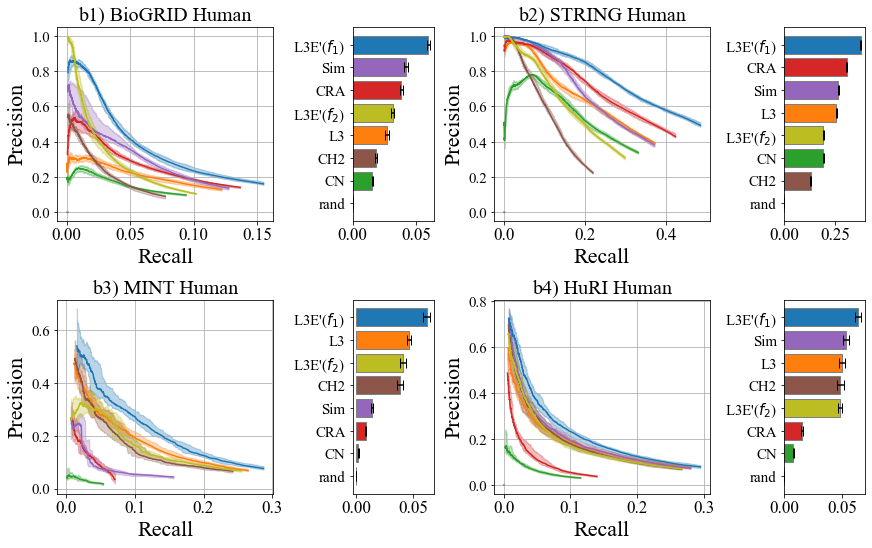

bioGRID_human
STRING_human
MINT_human
HuRI


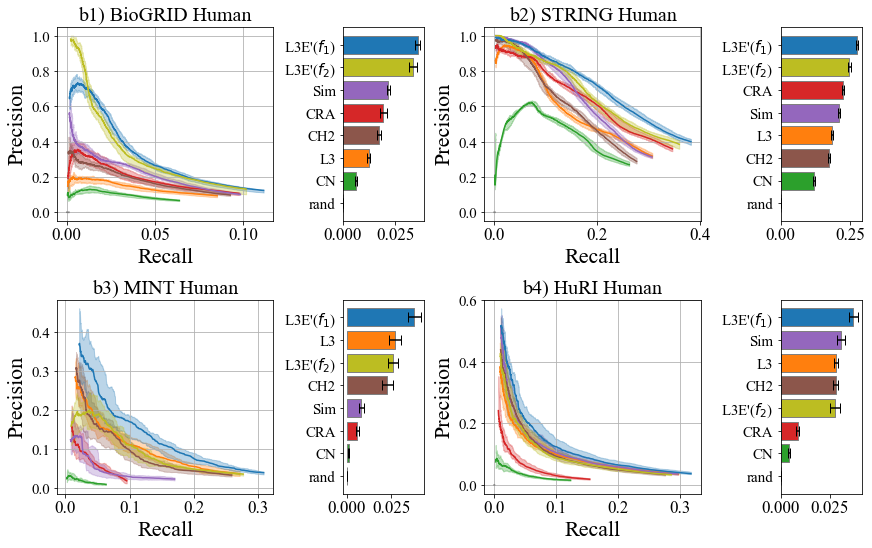

In [13]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']


for randSz in range(50, 91, 10):
    fig = plt.figure(constrained_layout=True, figsize=(12, 7.5))
    widths = [4,1.5,4,1.5]
    heights = [1,1]
    spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
    lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 2]),
                fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 2])]
    barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[0, 3]),
               fig.add_subplot(spec[1, 1]), fig.add_subplot(spec[1, 3])]


    # lineAxes
    dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
    dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
    for i in range(len(dss)):
        ds = dss[i]
        print(ds)
        ax = lineAxes[i]
        for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2", "rand"]:
            ax.fill_between(precRec[randSz][ds][method]['baseRec']
                            , precRec[randSz][ds][method]['lowerPrec']
                            , precRec[randSz][ds][method]['upperPrec']
                            , facecolor=colors[method], color=colors[method]
                            , alpha=0.3)
            ax.plot(precRec[randSz][ds][method]['baseRec']
                    , precRec[randSz][ds][method]['medianPrec']
                    , color=colors[method], label=method)
        ax.set_ylabel("Precision")
        ax.set_xlabel("Recall")
        ax.grid()
        ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

    # barAxes
    for i in range(len(dss)):
        ds = dss[i]
        ax = barAxes[i]

        xtick = [k for k in list(sorted_mean_auc[randSz][ds])]
        ax.barh([labels[x] for x in xtick], [sorted_mean_auc[randSz][ds][x] for x in xtick]
                          , xerr=[err_auc[randSz][ds][x] for x in xtick]
                          , color=[colors[x] for x in xtick]
                          , edgecolor='grey', capsize=5)

    plt.savefig("./img_experiments/L3E_human_PR_randSz{}.png".format(randSz), dpi=300)
    plt.show()

# PR AUC scatter

In [10]:
auc_perRandsz = auc_map.copy()

In [11]:
auc_map = {}
methods = ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]

for ds in set(df['ds']):
    auc_map[ds] = defaultdict(list)
    for method in methods:
        tmp_df = df[(df['ds'] == ds) & (df['method'] == method)]
        for  trial in range(10):
            auc_map[ds][method].append(metrics.auc([j/100 for j in range(50, 100, 10)],
                                                   [auc_perRandsz[j][ds][method][trial] for j in range(50, 100, 10)]))
            

sorted_mean_auc, err_auc = {}, {}
for ds in auc_map:
    sorted_mean_auc[ds], err_auc[ds] = {}, {}
    for method in auc_map[ds]:
        sorted_mean_auc[ds][method] = np.mean(auc_map[ds][method])
        err_auc[ds][method] = np.std(auc_map[ds][method])
    sorted_mean_auc[ds] = dict(sorted(sorted_mean_auc[ds].items(), key=lambda item: item[1]))

print(sorted_mean_auc)

{'bioGRID_human': {'CN': 0.01039756982162934, 'L3': 0.017251372802722098, 'CH2': 0.01765959930830188, 'CRA': 0.020781953375235827, 'Sim': 0.02256762083311166, 'L3E1_f2': 0.025968345136184706, 'L3E1_f1': 0.032948747280639776}, 'HuRI': {'CN': 0.0038253027609551397, 'CRA': 0.006901023729916027, 'L3E1_f2': 0.021724558522782714, 'CH2': 0.022971071353689976, 'L3': 0.023929242406881667, 'Sim': 0.024554587683922113, 'L3E1_f1': 0.02916253772313191}, 'MINT_human': {'CN': 0.0008070394822079083, 'CRA': 0.0027497247550368883, 'Sim': 0.006324723600127142, 'CH2': 0.017460042612635222, 'L3E1_f2': 0.017647811865392004, 'L3': 0.021570777814192678, 'L3E1_f1': 0.027124210883678203}, 'STRING_human': {'CN': 0.09500341526803588, 'CH2': 0.09834488319420806, 'L3': 0.12667355446283257, 'Sim': 0.12949021023594845, 'CRA': 0.1431998024781952, 'L3E1_f2': 0.14440358993647667, 'L3E1_f1': 0.17483689224373283}}


bioGRID_human
STRING_human
MINT_human
HuRI


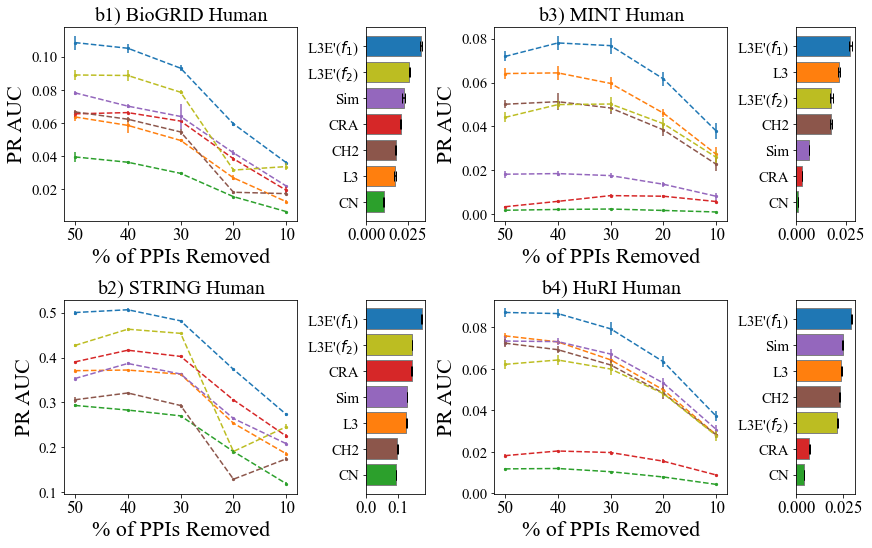

In [12]:
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=22)
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=18)
plt.rcParams["font.family"] = "Times New Roman"
hatches = ['', '\\', '\\', '\\', '\\', '\\', '\\/', '\\/']

fig = plt.figure(constrained_layout=True, figsize=(12, 7.5))
widths = [4,1,4,1]
heights = [1,1]
spec = fig.add_gridspec(ncols=4, nrows=2, width_ratios=widths, height_ratios=heights)
lineAxes = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[1, 0])
            , fig.add_subplot(spec[0, 2]), fig.add_subplot(spec[1, 2])]
barAxes = [fig.add_subplot(spec[0, 1]), fig.add_subplot(spec[1, 1])
           , fig.add_subplot(spec[0, 3]), fig.add_subplot(spec[1, 3])]


# lineAxes
dss = ['bioGRID_human', 'STRING_human', 'MINT_human', 'HuRI']
dsNames = ['BioGRID', 'STRING', 'MINT', 'HuRI']
for i in range(len(dss)):
    ds = dss[i]
    print(ds)
    ax = lineAxes[i]
    for method in ["CN", "L3", "CRA", "Sim", "CH2", "L3E1_f1", "L3E1_f2"]:
        ax.errorbar([randSz for randSz in range(50, 0, -10)]
                    , [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                    fmt='--', color=colors[method],
                    yerr=np.transpose(np.asarray(
                        [np.std(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)]
                    )))
        ax.scatter([randSz for randSz in range(50, 0, -10)],
                   [np.mean(auc_perRandsz[randSz][ds][method]) for randSz in range(50, 100, 10)],
                   s=5, color=colors[method])
        ax.set_ylabel("PR AUC")
    ax.set_xticks([randSz for randSz in range(50, 0, -10)])
    ax.set_xlim(ax.get_xlim()[::-1])
    ax.set_xlabel("% of PPIs Removed")
    ax.set_title("b{}) {} Human".format(i+1, dsNames[i]))

# barAxes
for i in range(len(dss)):
    ds = dss[i]
    ax = barAxes[i]
    
    xtick = [k for k in list(sorted_mean_auc[ds])]
    ax.barh([labels[x] for x in xtick], [sorted_mean_auc[ds][x] for x in xtick]
                      , xerr=[err_auc[ds][x] for x in xtick]
                      , color=[colors[x] for x in xtick]
                      , edgecolor='grey', capsize=5)
    
plt.savefig("./img_experiments/L3E_human_PRAUC.png", dpi=300)
plt.show()

In [35]:
# p val
# sample to do: top 2 both to third, between top 2
pairs = [['L3E1_f1', 'L3E1_f2'], ['L3E1_f1', 'CRA'], ['L3E1_f1', 'L3'], ['L3E1_f1', 'L3']]
for i in range(len(dss)):
    ds = dss[i]
    pop1 = auc_map[ds][pairs[i][0]]
    pop2 = auc_map[ds][pairs[i][1]]
    pVal = stats.ttest_ind(pop1, pop2)[1]
    print("{} {} {}: {}".format(ds, pairs[i][0], pairs[i][1], pVal))

bioGRID_human L3E1_f1 L3E1_f2: 2.355685798031155e-17
STRING_human L3E1_f1 CRA: 1.1468851422011721e-27
MINT_human L3E1_f1 L3: 1.1051980695875352e-12
HuRI L3E1_f1 L3: 3.7692508586252956e-18
